In [2]:
import numpy as np

In [8]:
# load the measured values of polarization fraction (pf) and polarization angle (pa)
data = np.load('gx131_02006801.npz'); obsid='Obs1'
data = np.load('gx131_03001101.npz'); obsid='Obs2'
data = np.load('gx131_03003401.npz'); obsid='Obs3'
t, S, mu, pf, pa = data['time'], data['N'], data['mu'], data['PD'], data['PA']

In [9]:
# calculate the posterior information for pa0
from importlib import reload
import bayes as bys
reload(bys)

ci = 0.68 
B = 0 # background counts
pa0_pdf = []
pa0_map = []
pa0_ci = []
for i in range(len(pf)):
	pdf_2d_i, pf0, pa0 = bys.polarization_posterior_2d(mu[i], S[i], B, pf[i], pa[i])
	pf0_pdf_i, pa0_pdf_i = bys.polarization_posterior_1d(pdf_2d_i, pf0, pa0)
	#bys.plot_posterior_1d(pf0_pdf_i, pa0_pdf_i, pf0, pa0)
	pa0_map_i, pa0_ci_i = bys.posterior_ci_min_pa(pa0, pa0_pdf_i, ci)
	pa0_pdf.append(pa0_pdf_i)
	pa0_map.append(pa0_map_i)
	pa0_ci.append(pa0_ci_i)

In [10]:
# model fitting for pa0 using MLE
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from importlib import reload
import pa_mle as mle
reload(mle)

pdf_interp = [interp1d(pa0, pdf/np.trapz(pdf, pa0), bounds_error=False, fill_value=0) for pdf in pa0_pdf]

# Optimize the parameters for three models: Constant, Linear, Double-valued
n_data = len(t)
initial_guess = [0.0]
neg_loglikelihood_const = lambda param: -mle.log_likelihood(param, pdf_interp, 'const')
res_const = minimize(neg_loglikelihood_const, initial_guess, method='Nelder-Mead', bounds=[(-90, 90)])
aic, bic = mle.compute_aic_bic(-res_const.fun, 1, n_data)
print('& Constant & $C = %.1f$ & %i & %i & %i \\\\'%(res_const.x[0], -res_const.fun, aic, bic))

if obsid == 'Obs3':
    initial_guess = [7., -40.]
else:
    initial_guess = [0., 10.]  # Initial values for parameters
neg_loglikelihood_linear = lambda param: -mle.log_likelihood(param, pdf_interp, 'linear', t)
res_lin = minimize(neg_loglikelihood_linear, initial_guess, method='Nelder-Mead', bounds=[(-15, 15), (-90, 90)])
aic, bic = mle.compute_aic_bic(-res_lin.fun, 2, n_data)
print('%s & Linear & $slope = %.2f, intercept = %.1f$ & %i & %i & %i \\\\'%(obsid, res_lin.x[0], res_lin.x[1], -res_lin.fun, aic, bic))


initial_guess = [-40., 28., 0.7]  # Initial values for parameters
neg_loglikelihood_bimodal = lambda param: -mle.log_likelihood(param, pdf_interp, 'bimodal')
res_doub = minimize(neg_loglikelihood_bimodal, initial_guess, method='Nelder-Mead', bounds=[(-90, 90), (-90, 90), (0, 1)])
aic, bic = mle.compute_aic_bic(-res_doub.fun, 3, n_data)
print('& Double-valued & $C_1 = %.1f, C_2 = %.1f, f_1 = %.2f$ & %i & %i & %i \\\\'%(res_doub.x[0], res_doub.x[1], res_doub.x[2], -res_doub.fun, aic, bic))



& Constant & $C = 29.6$ & -137 & 276 & 278 \\
Obs2 & Linear & $slope = -0.24, intercept = 35.1$ & -136 & 277 & 280 \\
& Double-valued & $C_1 = -40.7, C_2 = 30.0, f_1 = 0.15$ & -133 & 272 & 277 \\


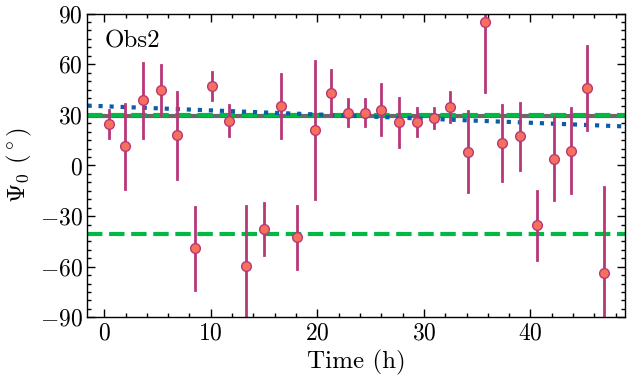

In [11]:
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scienceplots
plt.style.use(['science', 'notebook','no-latex'])
import matplotlib as mpl
cmap = mpl.colormaps['magma']

fs = 18
fig= plt.figure(figsize=(6.5, 4))
ax = fig.add_subplot(111)
l0, = ax.plot([t[0]-2, t[-1]+2], [res_const.x]*2, c='dimgray', lw=3)
l1, = ax.plot([t[0]-2, t[-1]+2], [res_doub.x[0]]*2, '--', c='C1', lw=3)
l1, = ax.plot([t[0]-2, t[-1]+2], [res_doub.x[1]]*2, '--', c='C1', lw=3)
l2, = ax.plot([t[0]-2, t[-1]+2], res_lin.x[0]*np.array([t[0]-2, t[-1]+2]) + res_lin.x[1], ':', c='C0', lw=3)
for i in range(len(t)):
    ax.plot([t[i], t[i]], pa0_ci[i], c=cmap(0.5), lw=2)
ax.plot(t, pa0_map, 'o', mec=cmap(0.5), mfc=cmap(0.7), ms=7)
ax.set_xlim(t[0]-2, t[-1]+2)
ax.set_ylim(-90, 90)
ax.set_xlabel('Time (h)', fontsize=fs)
ax.set_ylabel('$\Psi_0$ ($^\circ$)', fontsize=fs)
ax.text(0, 70, obsid, fontsize=fs, fontweight='bold')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='both', top=True, right=True, direction='in', labelsize=fs-1)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['savefig.bbox'] = 'tight'  # find bbox of figure
plt.tight_layout()
#plt.savefig('fig/gx131_%s.pdf'%obsid.lower())
plt.show()